# Capstone Project - Use clustering and multiple tabular predictors to predict the 1-day future price of gold
## N. Simon

Import the required libraries. Note that the ag_model data comes from https://github.com/aws/amazon-sagemaker-examples/tree/master/advanced_functionality/autogluon-tabular-containers

In [1]:
import os
import time
import io

import boto3
import sagemaker

import pandas as pd
import numpy as np

from sagemaker import KMeans
from sagemaker import utils
from sagemaker.serializers import CSVSerializer

# Helper wrappers referred earlier
from ag_model import (
    AutoGluonTraining,
    AutoGluonInferenceModel,
    AutoGluonTabularPredictor,
)

import matplotlib.pyplot as plt


In [2]:
# Get the start time to record how long it takes
startTime = time.perf_counter()
# Get the execution role
role = sagemaker.get_execution_role()
# Get the s3Client
s3Client = boto3.client("s3")
# Get the sagemaker session
sagemakerSession = sagemaker.session.Session()
# Get the region
region = sagemakerSession._region_name
# Get the default bucket
s3Bucket = sagemakerSession.default_bucket()

In [3]:
num_clusters = 4
# Retrieve the pre-processed data
response = s3Client.get_object(Bucket="sagemaker-studio-p0xlvix7lda", Key="Gold daily processed final.csv")
responseBody = response["Body"].read()
# We only need to bring in some of the columns, so we list them here. We use Date as the index
goldInfoTable = pd.read_csv(io.BytesIO(responseBody), header=0, delimiter=",", low_memory=False, parse_dates=['Date'], index_col=0, usecols=['Date', 'Normalised Gold Return', 'Normalised Gold Return 2 day back 1', 'Normalised Gold Return 4 day back 3', 'Normalised Gold Return 8 day back 7', 'Var 16 day', 'Normalised S&P Return', 'Normalised S&P Return 2 day back 1', 'Normalised S&P Return 4 day back 3', 'Normalised S&P Return 8 day back 7', 'Var 16 day.1', 'Tomorrow Gold Return'])
goldInfoTable.head()

,Var 16 day,Normalised Gold Return,Normalised Gold Return 2 day back 1,Normalised Gold Return 4 day back 3,Normalised Gold Return 8 day back 7,Var 16 day.1,Normalised S&P Return,Normalised S&P Return 2 day back 1,Normalised S&P Return 4 day back 3,Normalised S&P Return 8 day back 7,Tomorrow Gold Return
Date,,,,,,,,,,,
2006-01-26,0.013745,-0.323525,0.359369,0.322096,0.939482,0.006625,1.092031,0.072626,-1.129939,0.401029,-0.001787
2006-01-27,0.013338,-0.133952,0.190116,0.965259,0.876347,0.006686,1.161302,0.581902,-0.647845,0.184792,0.012708
2006-01-30,0.012713,0.999577,-0.346257,0.267636,0.963565,0.006686,0.171274,1.592265,-1.184882,-0.016867,0.008837
2006-01-31,0.011519,0.767178,0.669035,0.486221,0.245949,0.006339,-0.627284,0.994861,0.771635,-1.239087,-0.002453
2006-02-01,0.010985,-0.223273,1.394069,0.032610,0.827823,0.006281,0.296037,-0.319243,1.253555,-1.129202,0.005444


## Display plots of the data to show that it roughly fits normal distribution (excepting variance plots)

In [4]:
# Divide the histograms into buckets of this size
histBincount = 48

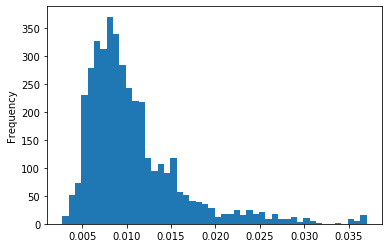

In [41]:
goldInfoTable['Var 16 day'].plot.hist(bins=histBincount)

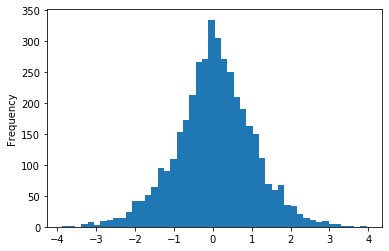

In [38]:
goldInfoTable['Normalised Gold Return'].plot.hist(bins=histBincount)

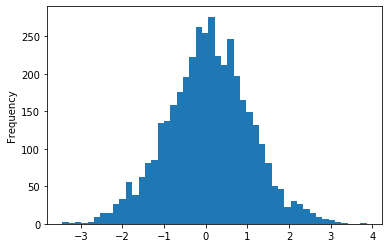

In [39]:
goldInfoTable['Normalised Gold Return 2 day back 1'].plot.hist(bins=histBincount)

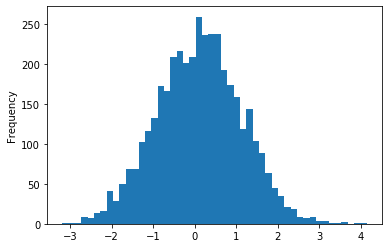

In [8]:
goldInfoTable['Normalised Gold Return 4 day back 3'].plot.hist(bins=histBincount)

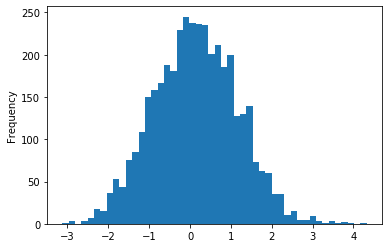

In [9]:
goldInfoTable['Normalised Gold Return 8 day back 7'].plot.hist(bins=histBincount)

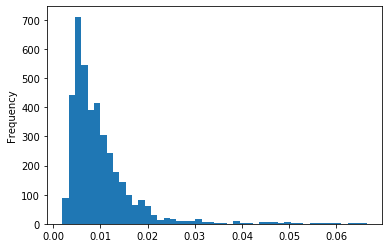

In [10]:
goldInfoTable['Var 16 day.1'].plot.hist(bins=histBincount)

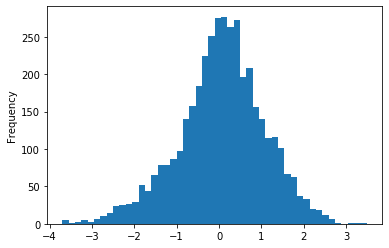

In [11]:
goldInfoTable['Normalised S&P Return'].plot.hist(bins=histBincount)

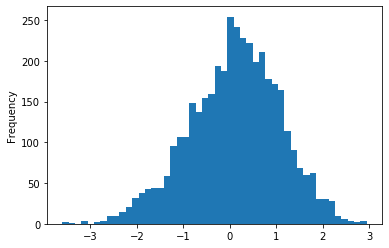

In [12]:
goldInfoTable['Normalised S&P Return 2 day back 1'].plot.hist(bins=histBincount)

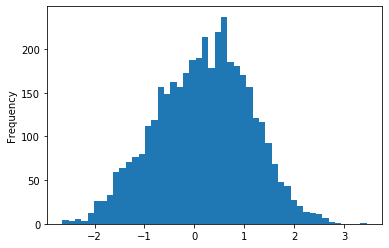

In [13]:
goldInfoTable['Normalised S&P Return 4 day back 3'].plot.hist(bins=histBincount)

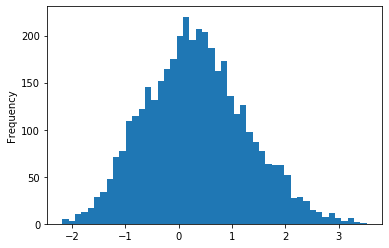

In [14]:
goldInfoTable['Normalised S&P Return 8 day back 7'].plot.hist(bins=histBincount)

In [58]:
# Generate and save copies of the generated histograms
for x in goldInfoTable.columns:
    fig=goldInfoTable[x].plot.hist(bins=histBincount).get_figure()
    fig.savefig('img/'+x+'.png')
    plt.close(fig)

In [15]:
# Split the data into training and testing data of size 3000:992
trainGoldInfoTable = goldInfoTable.loc[:"2017-12-26",:]
testGoldInfoTable  = goldInfoTable.loc["2017-12-27":,:]

In [16]:
kMeansTable = goldInfoTable[['Normalised Gold Return', 'Normalised Gold Return 2 day back 1', 'Normalised Gold Return 4 day back 3', 'Normalised Gold Return 8 day back 7', 'Var 16 day', 'Normalised S&P Return', 'Normalised S&P Return 2 day back 1', 'Normalised S&P Return 4 day back 3', 'Normalised S&P Return 8 day back 7', 'Var 16 day.1']]
trainKMeansTableNew = kMeansTable.iloc[:3000,:]
testKMeansTableNew = kMeansTable.iloc[3000:,:]

In [17]:
trainKMeansTableNew.shape

(3000, 10)

In [18]:
testKMeansTableNew.shape

(992, 10)

### Setup a KMeans trained endpoint.
In this section we train a KMeans endpoint and then deploy it to provide a mechanism for spliting the data into clusters upon which we may be able to perform more accurate tabular prediction.

In [19]:
# Only run the kmeans clustering if we are categorising into more than 1 cluster
if num_clusters > 1:
    kmeans = KMeans(
        role=role,
        instance_count=1,
        instance_type="ml.c4.xlarge",
        output_path="s3://" + s3Bucket + "/groups/",
        k=num_clusters,
    )


In [20]:
if num_clusters > 1:
    kmeans.fit(kmeans.record_set(trainKMeansTableNew.values.astype("float32")))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-12-29 03:18:43 Starting - Starting the training job...
2021-12-29 03:19:07 Starting - Launching requested ML instancesProfilerReport-1640747923: InProgress
......
2021-12-29 03:20:07 Starting - Preparing the instances for training.........
2021-12-29 03:21:44 Downloading - Downloading input data...
2021-12-29 03:22:07 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/29/2021 03:22:21 INFO 140185024227136] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false', '_enable_profiler': 'false', '_k

In [21]:
if num_clusters > 1:
    kmeans_predictor = kmeans.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


------------!

In [22]:
# Get the predictions for the training data. We will use this later when training with the tabular predictors.
if num_clusters > 1:
    trainResult = kmeans_predictor.predict(trainKMeansTableNew.values.astype("float32"))

In [23]:
# Get the predictions for the testing data. We will use this later when training with the tabular predictors.
if num_clusters > 1:
    testResult = kmeans_predictor.predict(testKMeansTableNew.values.astype("float32"))

In [24]:
# Put the cluster information into the training data
if num_clusters > 1:
    trainResultList = [int(i.label["closest_cluster"].float32_tensor.values[0]) for i in trainResult]
else:
    trainResultList = [0]*len(trainGoldInfoTable)
trainGoldInfoTable['Cluster'] = trainResultList
trainGoldInfoTable.head()
# Save a copy of the data with cluster information
trainGoldInfoTable.to_csv("data/clusteredTrain.csv")
# Save the data with cluster information into cluster specific files
[trainGoldInfoTable[trainGoldInfoTable['Cluster']==i].to_csv("data/train" + str(i) + ".csv") for i in np.unique(trainGoldInfoTable['Cluster'].values.ravel())]
trainTableClustered = [trainGoldInfoTable[trainGoldInfoTable['Cluster']==i] for i in np.unique(trainGoldInfoTable['Cluster'].values.ravel())]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [25]:
# Put the cluster information into the training data
if num_clusters > 1:
    testResultList = [int(i.label["closest_cluster"].float32_tensor.values[0]) for i in testResult]
else:
    testResultList = [0]*len(testGoldInfoTable)
testGoldInfoTable['Cluster'] = testResultList
testGoldInfoTable.head()
# Save a copy of the data with cluster information
testGoldInfoTable.to_csv("data/clusteredTest.csv")
# Save the data with cluster information into cluster specific files
[testGoldInfoTable[testGoldInfoTable['Cluster']==i].to_csv("data/test" + str(i) + ".csv") for i in np.unique(testGoldInfoTable['Cluster'].values.ravel())]
testTableClustered = [testGoldInfoTable[testGoldInfoTable['Cluster']==i] for i in np.unique(testGoldInfoTable['Cluster'].values.ravel())]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [26]:
trainTableClustered[0].head()

,Var 16 day,Normalised Gold Return,Normalised Gold Return 2 day back 1,Normalised Gold Return 4 day back 3,Normalised Gold Return 8 day back 7,Var 16 day.1,Normalised S&P Return,Normalised S&P Return 2 day back 1,Normalised S&P Return 4 day back 3,Normalised S&P Return 8 day back 7,Tomorrow Gold Return,Cluster
Date,,,,,,,,,,,,
2006-10-04,0.014696,-1.688451,-1.792479,0.501778,0.032671,0.004858,2.482394,-0.189576,0.735563,0.458248,0.016014,0
2006-10-23,0.016191,-1.385230,0.304055,0.675176,-0.781826,0.004346,1.415634,0.333558,0.250727,1.925469,0.008108,0
2008-02-12,0.013348,-1.258214,0.982190,-0.107177,0.568684,0.014308,0.507810,0.082063,-1.465230,1.601175,-0.000992,0
2008-04-01,0.020555,-1.768243,-1.181996,0.772399,-0.892039,0.021288,1.686243,-0.076668,-0.066249,0.732223,0.013931,0
2008-04-18,0.016796,-1.748500,0.503181,-0.156242,0.067859,0.013283,1.365614,1.241884,-0.557491,0.794750,0.002741,0


### Train K TabularPredictors using autogluon

In [27]:
ag = AutoGluonTraining(
    role=role,
    entry_point="scripts/hpo.py",
    region=region,
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    framework_version="0.3.1",
    base_job_name="autogluon-tabular-train",
)


In [28]:
model=[0]*num_clusters
model_data=[0]*num_clusters
for x in range(num_clusters):
    s3_prefix = f"autogluon_sm/{utils.sagemaker_timestamp()}"
    train_input = ag.sagemaker_session.upload_data(
        path=os.path.join("data", "train"+str(x)+".csv"), key_prefix=s3_prefix
    )
    eval_input = ag.sagemaker_session.upload_data(
        path=os.path.join("data", "test"+str(x)+".csv"), key_prefix=s3_prefix
    )
    config_input = ag.sagemaker_session.upload_data(
        path=os.path.join("ag_configs", "config-full.yaml"), key_prefix=s3_prefix
    )

    job_name = utils.unique_name_from_base("test-autogluon-image")
    ag.fit(
        {"config": config_input, "train": train_input, "test": eval_input},
        job_name=job_name,
    )

    endpoint_name = sagemaker.utils.unique_name_from_base("sagemaker-autogluon-serving-trained-model")
    model_data[x] = 's3://' + os.path.join(sagemakerSession.default_bucket(), job_name, 'output', 'model.tar.gz')

    instance_type = "ml.m5.2xlarge"

    model[x] = AutoGluonInferenceModel(
        model_data=model_data[x],
        role=role,
        region=region,
        framework_version="0.3.1",
        instance_type=instance_type,
        source_dir="scripts",
        entry_point="hpo.py",
    )

2021-12-29 03:29:05 Starting - Starting the training job...
2021-12-29 03:29:08 Starting - Launching requested ML instancesProfilerReport-1640748544: InProgress
......
2021-12-29 03:30:17 Starting - Preparing the instances for training.........
2021-12-29 03:31:58 Downloading - Downloading input data...
2021-12-29 03:32:31 Training - Training image download completed. Training in progress..2021-12-29 03:32:31,366 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2021-12-29 03:32:31,367 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-12-29 03:32:31,377 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{}', 'SM_USER_ENTRY_POINT': 'hpo.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1","hosts":["algo-1"],"network_interface_name":"eth0"}', 'SM_INPUT_DATA_CONFIG': '{"config":{"RecordWra

### Deploy K TabularPredictors using autogluon

In [33]:
predictor = [model[x].deploy(initial_instance_count=1, serializer=CSVSerializer(), instance_type=instance_type) for x in range(num_clusters)]

ResourceLimitExceeded: An error occurred (ResourceLimitExceeded) when calling the CreateEndpoint operation: The account-level service limit 'ml.m5.2xlarge for endpoint usage' is 30 Instances, with current utilization of 30 Instances and a request delta of 1 Instances. Please contact AWS support to request an increase for this limit.

In [ ]:
### Get results from the clustered data through the TabularPredictor predictors

In [32]:
results = [predictor[x].predict(testTableClustered[x].drop(columns=['Cluster']).to_csv(index=False, header=False)) for x in range(num_clusters)]

NameError: name 'predictor' is not defined

### Close down all of the endpoints.
We could leave them up and use lambda functions and a state machine to put this into production making predictions for individual days.

In [34]:
if num_clusters > 1:
    kmeans_predictor.delete_endpoint()

for x in range(num_clusters):
    predictor[x].delete_endpoint()


NameError: name 'predictor' is not defined

In [ ]:
processedResults = [list(map(lambda y: y[0], results[x])) for x in range(num_clusters)]
for x in range(num_clusters):
    testTableClustered[x]['prediction'] = processedResults[x]

In [ ]:
testTableClustered[0].head()

In [ ]:
predictionTable=pd.concat([testTableClustered[x] for x in range(num_clusters)]).sort_index()

In [ ]:
predictionTable.head()

In [ ]:
predictionTable.to_csv('data/prediction_'+str(num_clusters)+'.csv')

In [ ]:
endTime = time.perf_counter()
print(endTime - startTime)